<h1><center>Моделирование временных рядов и поиск аномалий</center></h1>
<h2><center>Домашнее задание 2: прогнозирование временных рядов</center></h2>

**Мягкий дедлайн:** 23:59MSK 24.11.2024

**Жесткий дедлайн:** 23:59MSK 30.11.2024

In [31]:
!pip install -r requirements.txt

In [32]:
import warnings
import pandas as pd
import numpy as np
from copy import deepcopy

warnings.filterwarnings("ignore")

В данной задаче мы будем решать одну из актуальных практических задач, с которыми, в том числе, сталкиваются разработчики ETNA - прогнозирование объема необходимой наличности в банкоматах. Пожалуй, ни для кого не секрет, что отсутствие необходимой суммы в банкомате не делает клиента банка счастливее. В то же время, избыток заправленной в банкомат наличности приводит к упущенной выгоде - ведь, в конечном счете, эти деньги могли быть размещены в качестве краткосрочного депозита на межбанковском рынке. Для кредитной организации с обширной сетью банкоматов даже незначительное улучшение качества предсказания способно внести значительный вклад в прибыльность этой ветки бизнеса.

В качестве инструмента воспользуемся библиотекой ETNA, документацию можно прочитать [тут](https://docs.etna.ai/stable/), и [чат](https://t.me/etna_support) комьюнити.

Мы будем использовать дневные данные реальных банкоматов для чего возьмем мультисегментный датасет.

In [33]:
url = 'https://gist.githubusercontent.com/Polzovat123/4d6d5e544e93429c2d3db29196e9c918/raw/24b27e60f587128d71678e267f51cd48472c6a84/atms_daily_cash.csv'

df = pd.read_csv(url, index_col=False)

Полученные данные были просуммированы по банкоматам и дням эксплуатации, после чего залиты в gist, откуда мы и берем их.

Взглянем на то, что представляют из себя данные после этих действий:

In [34]:
df.head()

datetime  atm_id  operation_value
0  2017-08-16      74         2.059266
1  2017-08-17      74         1.029633
2  2017-08-18      74         0.686422
3  2017-08-19      74        33.301267
4  2017-08-20      74       -12.237921

### Задание 1. EDA (1 балл)

Проведите разведывательный анализ данных с помощью `ETNA`- постройте графики, на которых можно судить о наличии тренда, сезонности и прочих зависимостей. Проанализируйте корреляции. Какие выводы вы можете сделать?

Ссылку на туториал по EDA можно найти [тут](https://docs.etna.ai/stable/tutorials/103-EDA.html#EDA).

In [35]:
from etna.datasets import TSDataset

In [36]:
df_atm = df.reset_index()
df_atm['index'] = pd.to_datetime(df_atm['datetime'])
df_atm = df_atm.drop(['datetime'], axis=1)
df_atm

index  atm_id  operation_value
0    2017-08-16      74         2.059266
1    2017-08-17      74         1.029633
2    2017-08-18      74         0.686422
3    2017-08-19      74        33.301267
4    2017-08-20      74       -12.237921
...         ...     ...              ...
8456 2018-09-26     106         2.794718
8457 2018-09-27     106      -106.787632
8458 2018-09-28     106       153.091690
8459 2018-09-29     106        49.775392
8460 2018-09-30     106        -0.294181

[8461 rows x 3 columns]

In [37]:
df_atm = df_atm.rename(columns={'index': 'timestamp'})
df_atm = df_atm.rename(columns={'atm_id': 'segment'})
df_atm = df_atm.rename(columns={'operation_value': 'target'})

df_atm.head()


timestamp  segment     target
0 2017-08-16       74   2.059266
1 2017-08-17       74   1.029633
2 2017-08-18       74   0.686422
3 2017-08-19       74  33.301267
4 2017-08-20       74 -12.237921

In [38]:
df_atm_tsd = TSDataset(df_atm, freq='D')

In [39]:
df_atm_tsd.describe()

start_timestamp end_timestamp  length  num_missing  num_segments  \
segments                                                                    
100           2017-08-11    2018-09-30     416            3            20   
101           2017-08-11    2018-09-30     416            3            20   
102           2017-08-02    2018-09-30     425            3            20   
103           2017-08-08    2018-09-30     419            3            20   
104           2017-08-07    2018-09-30     420            3            20   
105           2017-07-28    2018-09-30     430            3            20   
106           2017-08-09    2018-09-30     418            3            20   
74            2017-08-16    2018-09-30     411            3            20   
85            2017-08-03    2018-09-30     424            3            20   
86            2017-08-01    2018-09-30     426            3            20   
87            2017-06-09    2018-09-30     479            3            20   
88            2017-08-14    2018-09-30     413            3            20   
90            2017-07-27    2018-09-30     431            3            20   
91            2017-07-19    2018-09-30     439            3            20   
93            2017-08-12    2018-09-30     415            3            20   
94            2017-08-10    2018-09-30     417            3            20   
96            2017-07-28    2018-09-30     430            3            20   
97            2017-08-16    2018-09-30     411            3            20   
98            2017-08-17    2018-09-30     410            3            20   
99            2017-08-16    2018-09-30     411            3            20   

          num_exogs  num_regressors  num_known_future freq  
segments                                                    
100               0               0                 0    D  
101               0               0                 0    D  
102               0               0                 0    D  
103               0               0                 0    D  
104               0               0                 0    D  
105               0               0                 0    D  
106               0               0                 0    D  
74                0               0                 0    D  
85                0               0                 0    D  
86                0               0                 0    D  
87                0               0                 0    D  
88                0               0                 0    D  
90                0               0                 0    D  
91                0               0                 0    D  
93                0               0                 0    D  
94                0               0                 0    D  
96                0               0                 0    D  
97                0               0                 0    D  
98                0               0                 0    D  
99                0               0                 0    D

In [40]:
from etna.analysis import acf_plot
from etna.analysis import cross_corr_plot
from etna.analysis import distribution_plot
from etna.analysis import plot_correlation_matrix

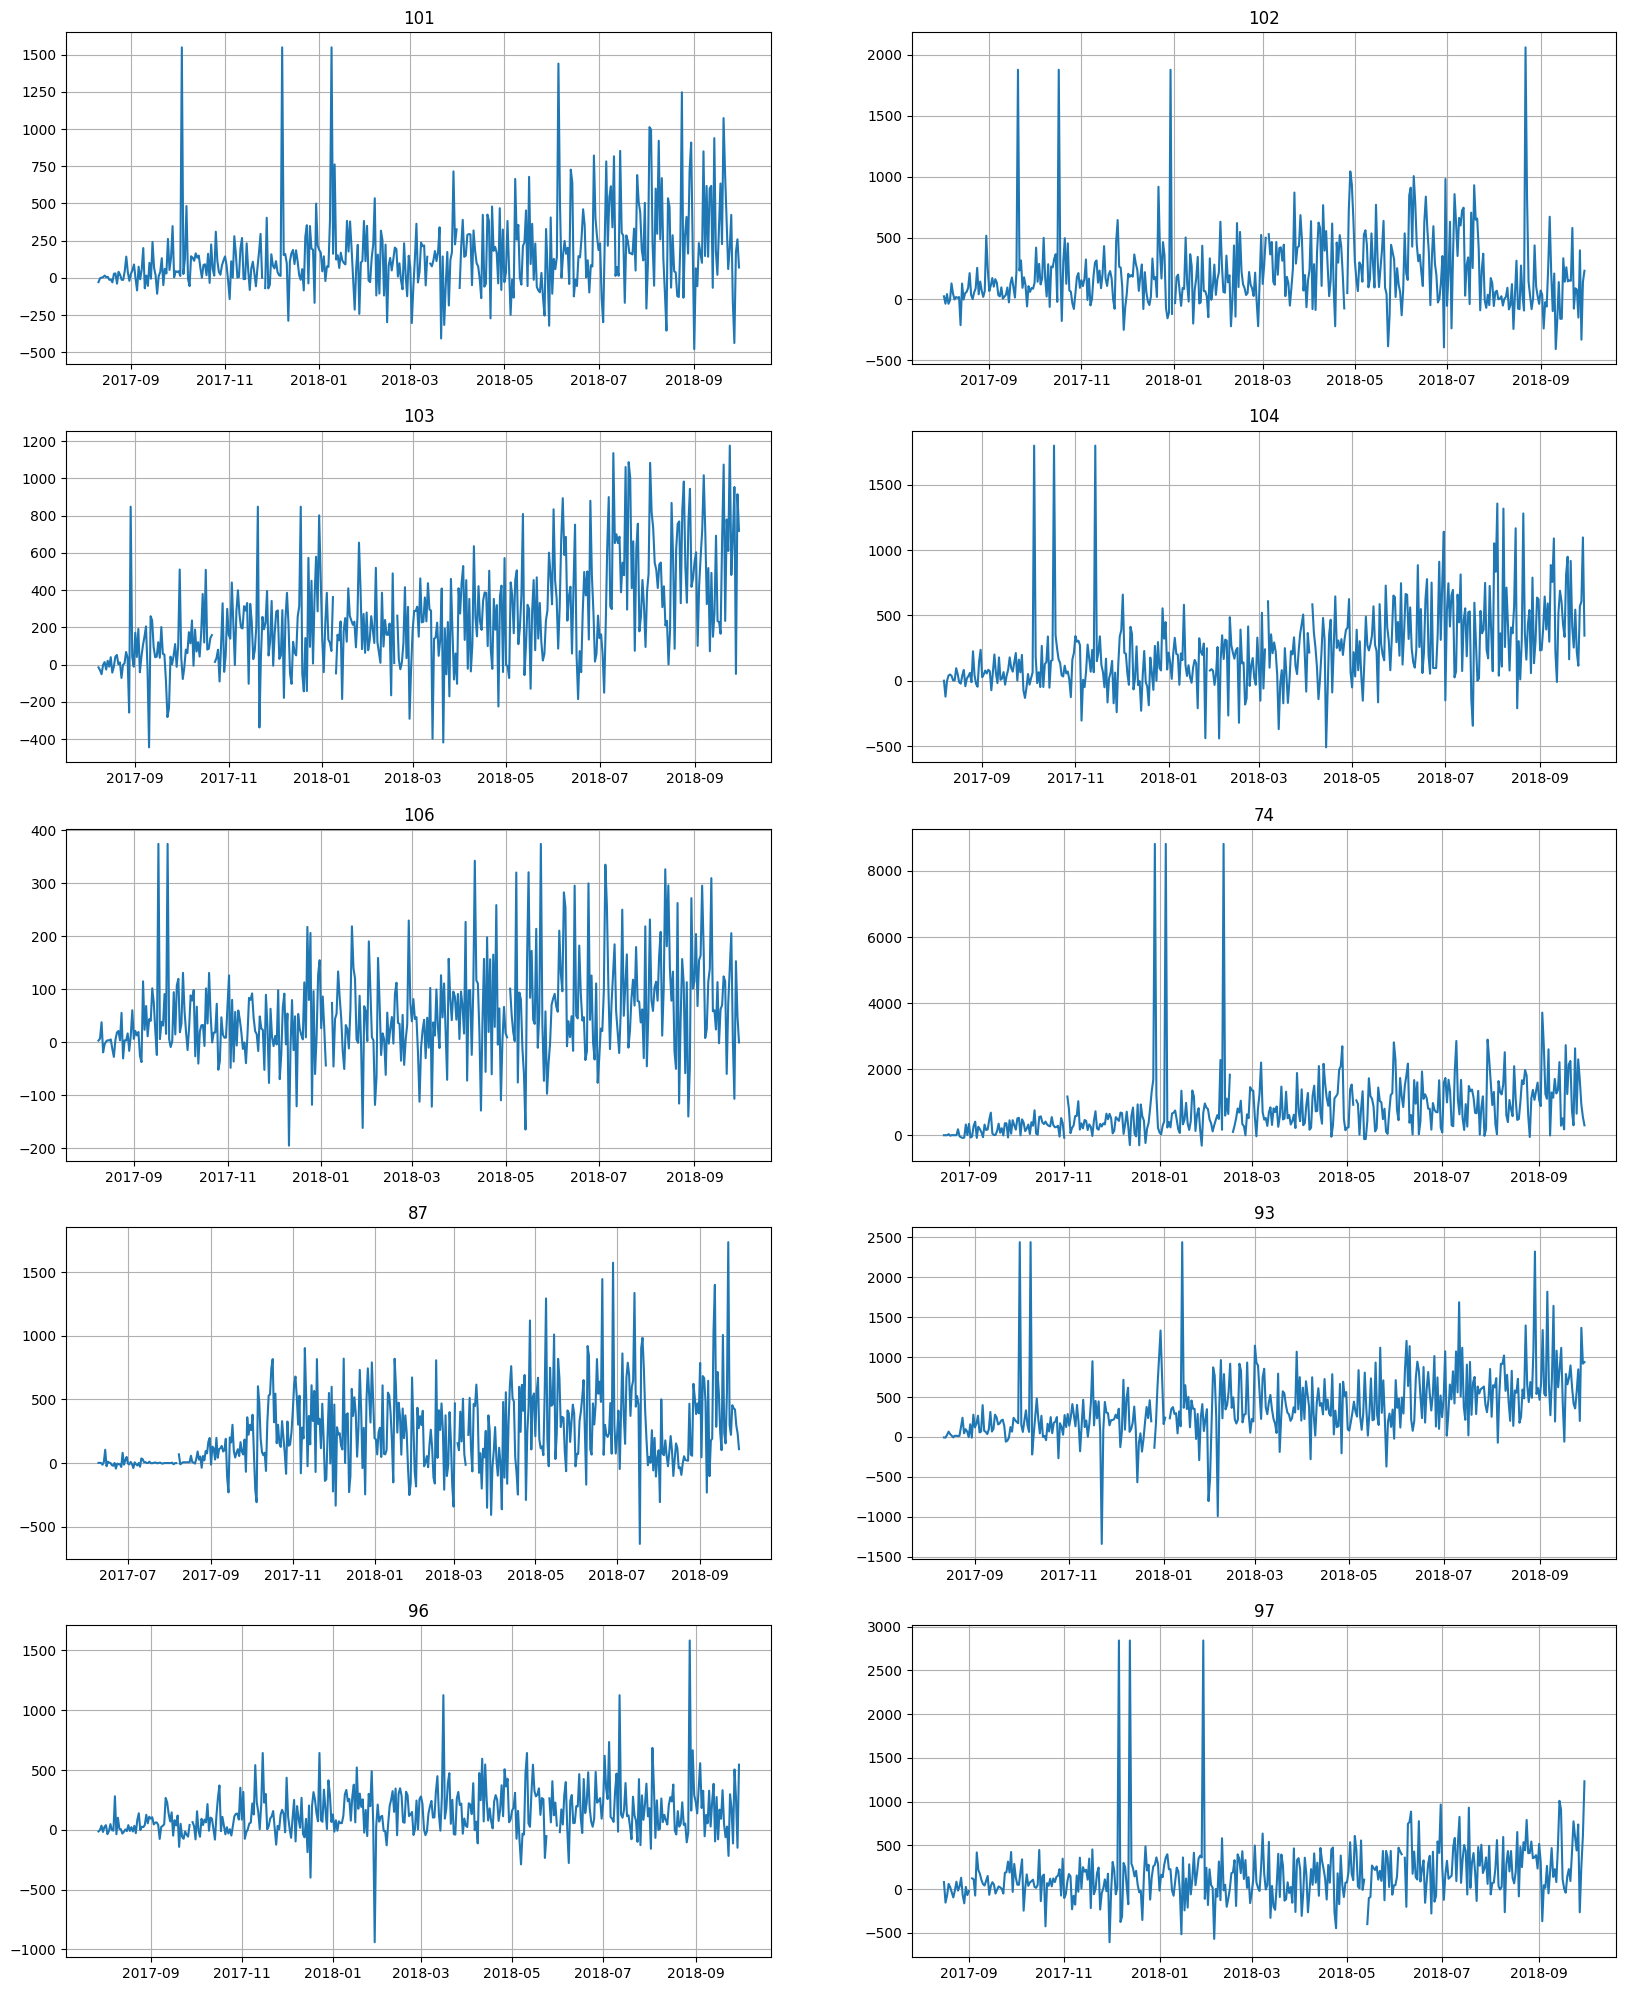

In [41]:
df_atm_tsd.plot()

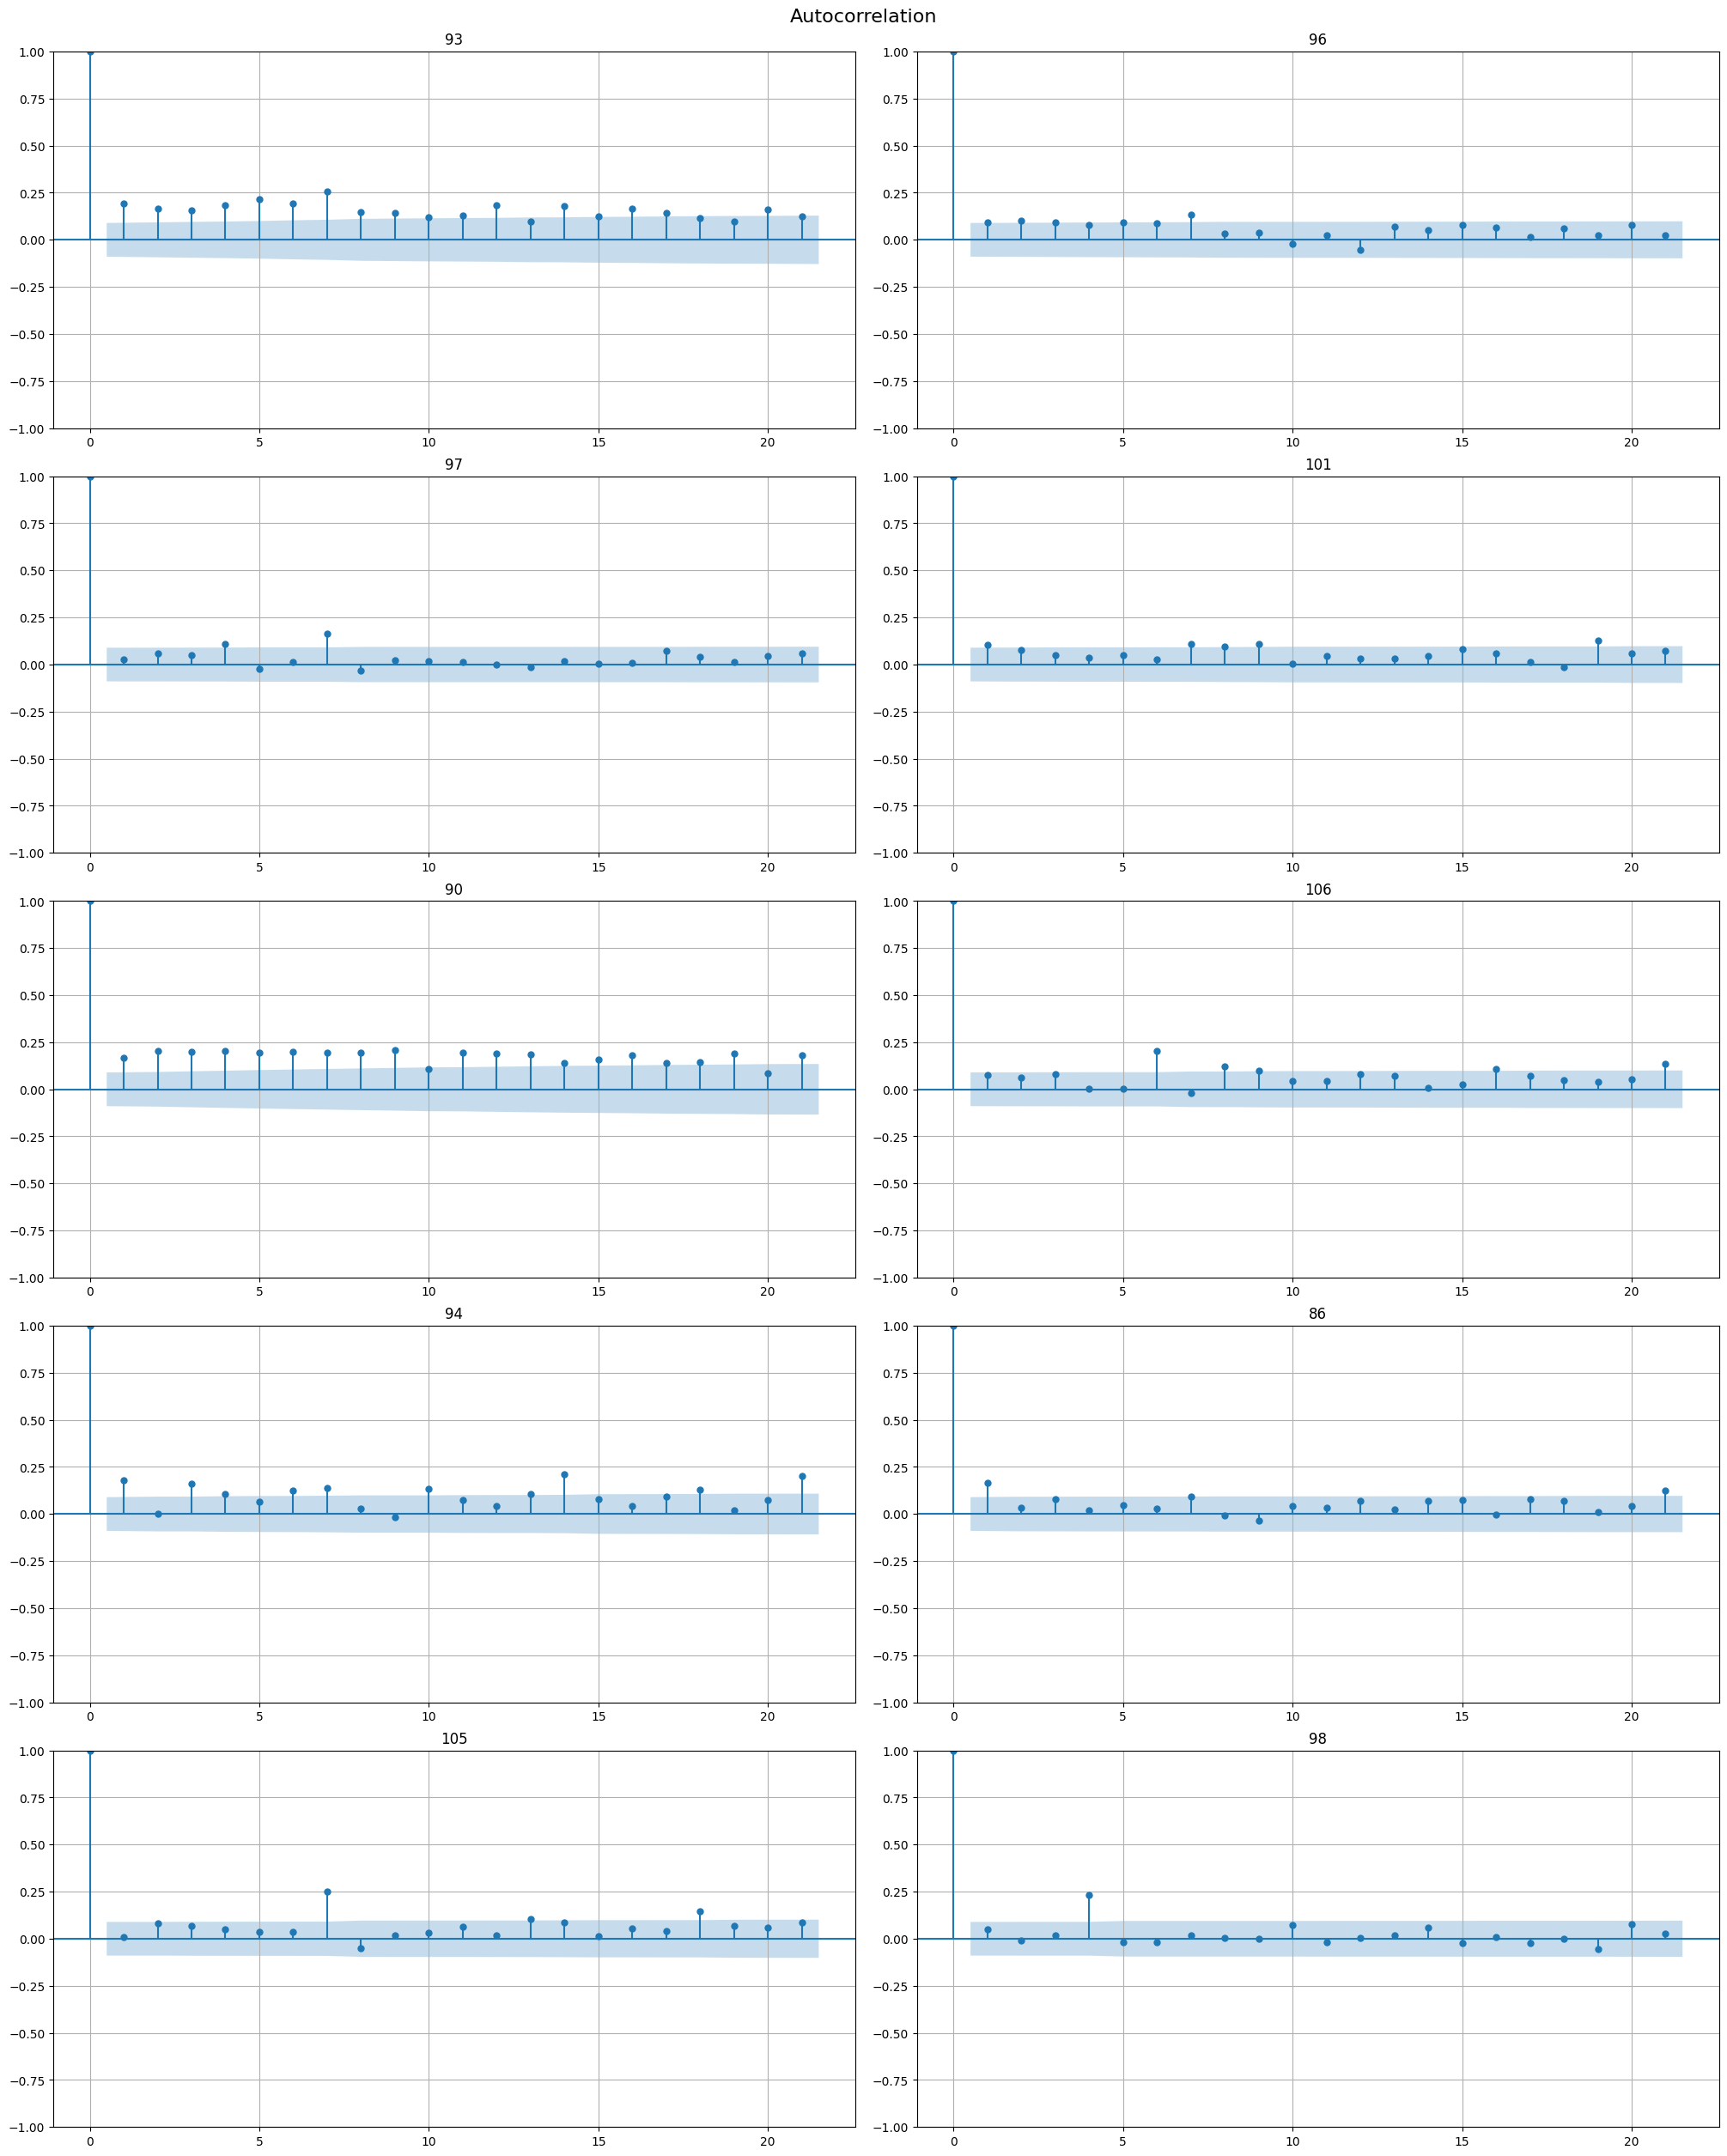

In [42]:
acf_plot(df_atm_tsd, lags=21)

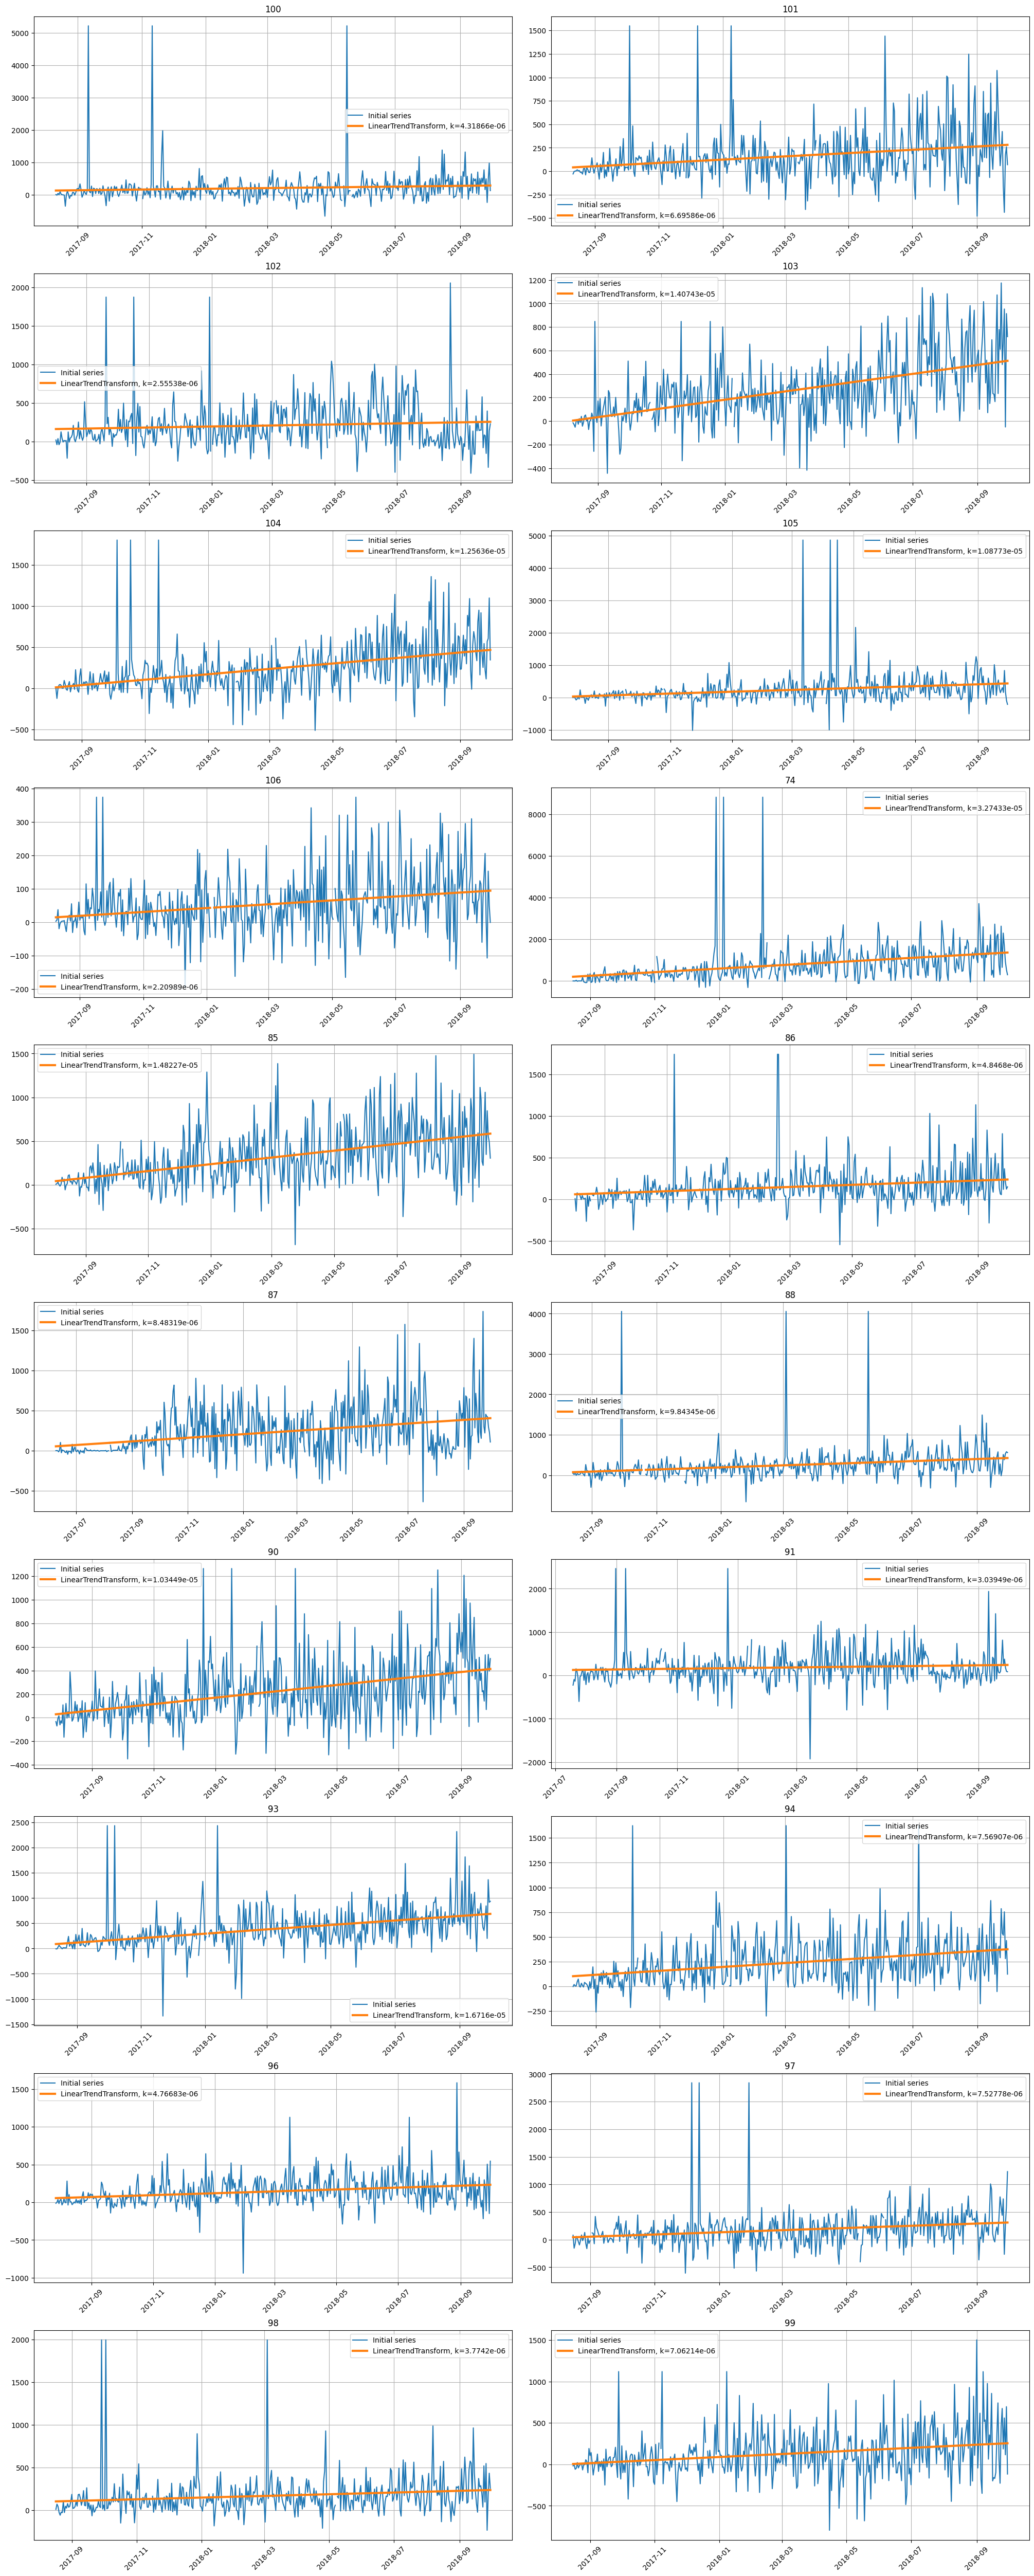

In [43]:
from etna.analysis import plot_trend
from etna.transforms import LinearTrendTransform

plot_trend(df_atm_tsd, trend_transform=LinearTrendTransform(in_column="target"))

**Результат**

В данных можно заметить положительный тренд, отсутствие сезонности и, в основном, отсутствие связи между текущими значениями ряда и их прошлыми значениями.

### Задание 2. Работа с пропущенными значениями и выбросами (1 балл)

Проанализируйте, есть ли в данных пропущенные значения, и подберите оптимальный метод их заполнения средствами ETNA. Какие методы вы выберете и почему? Совет: возможно, лучше сохранить заполненные данные в отдельный объект, поскольку некоторые модели заполняют пропуски встроенными методами, и подача на вход "сырых" данных (на языке временных рядов это данные с нерегулярными интервалами) может принести лучший результат.

Импорты всех необходимых компонент произведите самостоятельно.

In [44]:
from etna.transforms import MeanTransform
from etna.transforms import TimeSeriesImputerTransform
from etna.analysis import plot_anomalies, get_anomalies_density

Проверьте ряды на наличие выбросов, и очистите их соответствующим образом. Обоснуйте выбор.

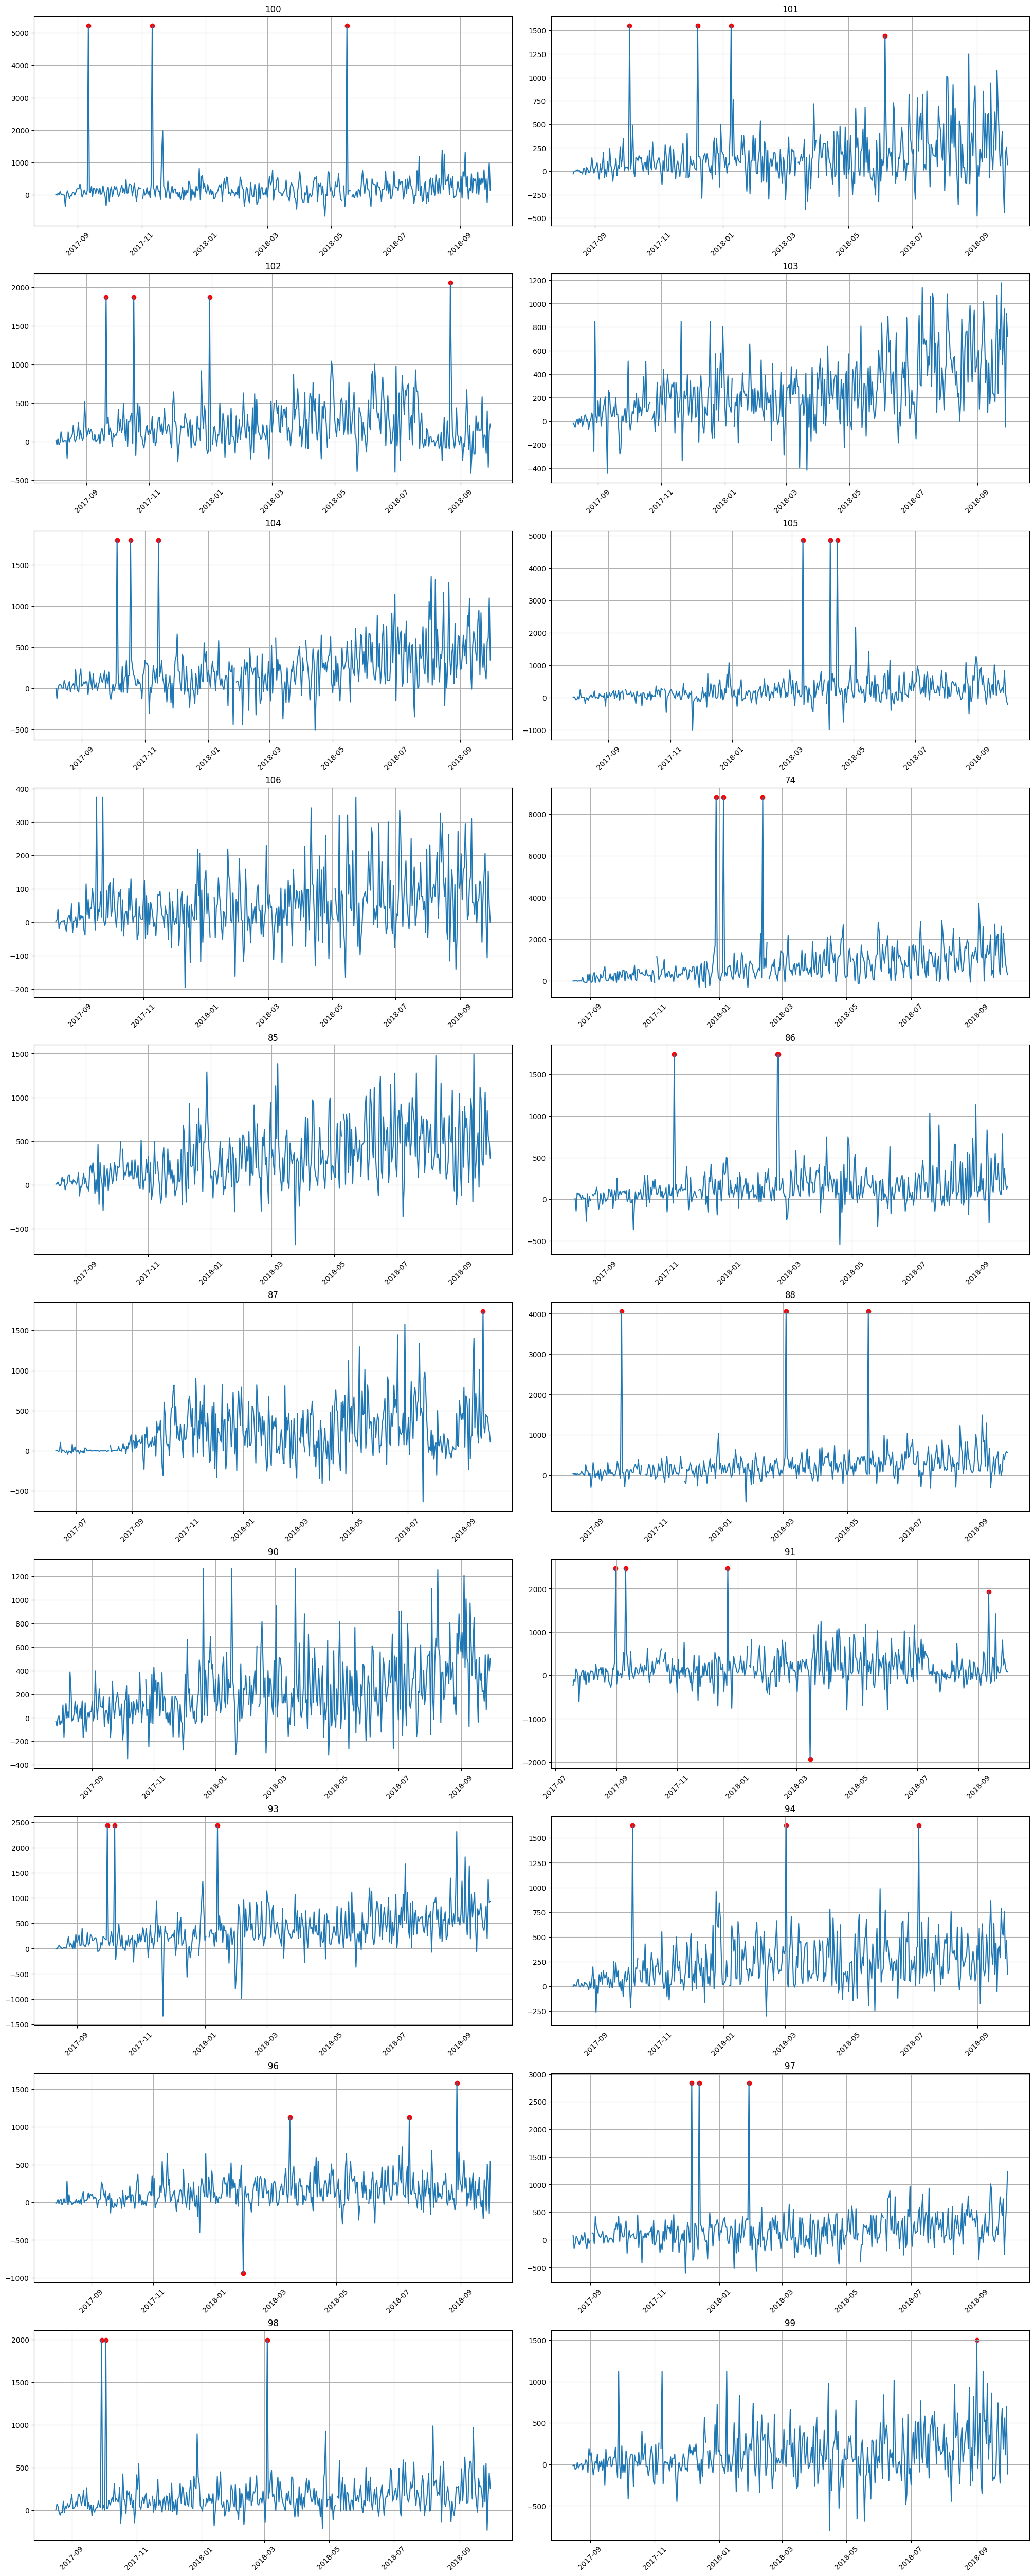

In [45]:
anomalies = get_anomalies_density(df_atm_tsd, window_size=30, distance_coef=5, n_neighbors=25)
plot_anomalies(df_atm_tsd, anomalies)

In [46]:
for segment in df_atm_tsd.segments:
    if segment in anomalies:
        df_atm_tsd.df.loc[anomalies[segment], (segment, "target")] = None

In [47]:
mean_transform = TimeSeriesImputerTransform(strategy="mean")

df_atm_tsd_transformed = TSDataset(df_atm, freq="D")
df_atm_tsd_transformed.fit_transform([mean_transform])
df_atm_tsd_transformed.describe()

start_timestamp end_timestamp  length  num_missing  num_segments  \
segments                                                                    
100           2017-08-11    2018-09-30     416            0            20   
101           2017-08-11    2018-09-30     416            0            20   
102           2017-08-02    2018-09-30     425            0            20   
103           2017-08-08    2018-09-30     419            0            20   
104           2017-08-07    2018-09-30     420            0            20   
105           2017-07-28    2018-09-30     430            0            20   
106           2017-08-09    2018-09-30     418            0            20   
74            2017-08-16    2018-09-30     411            0            20   
85            2017-08-03    2018-09-30     424            0            20   
86            2017-08-01    2018-09-30     426            0            20   
87            2017-06-09    2018-09-30     479            0            20   
88            2017-08-14    2018-09-30     413            0            20   
90            2017-07-27    2018-09-30     431            0            20   
91            2017-07-19    2018-09-30     439            0            20   
93            2017-08-12    2018-09-30     415            0            20   
94            2017-08-10    2018-09-30     417            0            20   
96            2017-07-28    2018-09-30     430            0            20   
97            2017-08-16    2018-09-30     411            0            20   
98            2017-08-17    2018-09-30     410            0            20   
99            2017-08-16    2018-09-30     411            0            20   

          num_exogs  num_regressors  num_known_future freq  
segments                                                    
100               0               0                 0    D  
101               0               0                 0    D  
102               0               0                 0    D  
103               0               0                 0    D  
104               0               0                 0    D  
105               0               0                 0    D  
106               0               0                 0    D  
74                0               0                 0    D  
85                0               0                 0    D  
86                0               0                 0    D  
87                0               0                 0    D  
88                0               0                 0    D  
90                0               0                 0    D  
91                0               0                 0    D  
93                0               0                 0    D  
94                0               0                 0    D  
96                0               0                 0    D  
97                0               0                 0    D  
98                0               0                 0    D  
99                0               0                 0    D

**Итог**

Учитывая, что пропусков не слишком много и данные стабильны без ярко выраженного тренда или сезонности, то подойдет метод среднего или медианного значения.

### Задание 3. Построение Prophet (1 балл)

Постройте прогнозы с помощью Prophet и `etna.Pipeline`, под капотом `etna.Pipeline` обучит `ProphetModel` для каждого сегмента в отдельности. После этого оцените качество по SMAPE на кросс-валидации. В качестве горизонта предсказания возьмите 5 дней - этого же горизонта будем придерживаться и в дальнейшем.

Отрисуйте получившийся прогноз.

In [48]:
from etna.pipeline import Pipeline
from etna.models import ProphetModel
from etna.metrics import SMAPE, MAE
from etna.analysis import plot_backtest

In [49]:
HORIZON = 5

In [50]:
# Pipeline of transforms with a final estimator.
pipeline = Pipeline(
    model=ProphetModel(),
    horizon=HORIZON
)
# Run backtest with the pipeline.
metrics, forecasts, _ = pipeline.backtest(
    ts=df_atm_tsd_transformed,
    metrics=[SMAPE(), MAE()],
    n_folds=2
)

21:42:59 - cmdstanpy - INFO - Chain [1] start processing
21:42:59 - cmdstanpy - INFO - Chain [1] done processing
21:42:59 - cmdstanpy - INFO - Chain [1] start processing
21:42:59 - cmdstanpy - INFO - Chain [1] done processing
21:42:59 - cmdstanpy - INFO - Chain [1] start processing
21:42:59 - cmdstanpy - INFO - Chain [1] done processing
21:42:59 - cmdstanpy - INFO - Chain [1] start processing
21:42:59 - cmdstanpy - INFO - Chain [1] done processing
21:42:59 - cmdstanpy - INFO - Chain [1] start processing
21:42:59 - cmdstanpy - INFO - Chain [1] done processing
21:42:59 - cmdstanpy - INFO - Chain [1] start processing
21:42:59 - cmdstanpy - INFO - Chain [1] done processing
21:42:59 - cmdstanpy - INFO - Chain [1] start processing
21:42:59 - cmdstanpy - INFO - Chain [1] done processing
21:42:59 - cmdstanpy - INFO - Chain [1] start processing
21:42:59 - cmdstanpy - INFO - Chain [1] done processing
21:42:59 - cmdstanpy - INFO - Chain [1] start processing
21:42:59 - cmdstanpy - INFO - Chain [1]

In [51]:
metrics[["SMAPE", "MAE"]].mean()

SMAPE     70.233639
MAE      243.166896
dtype: float64

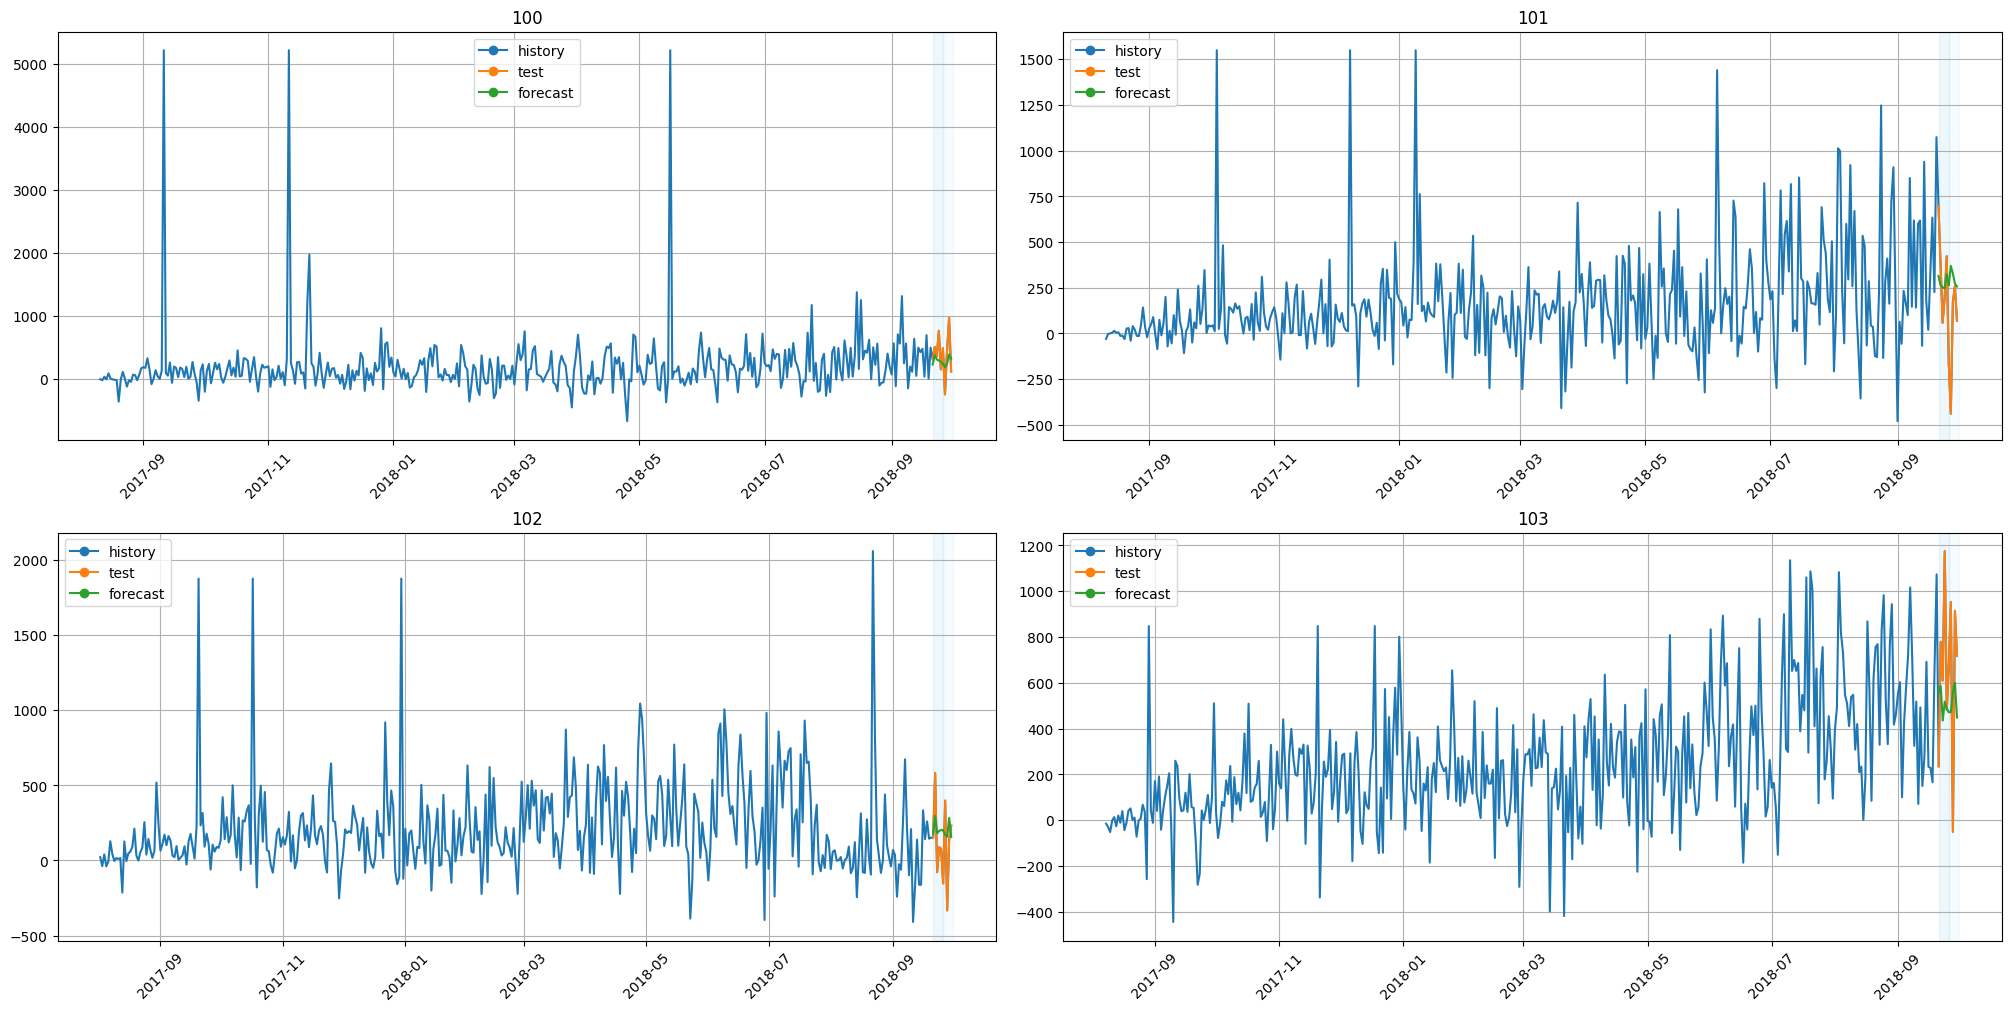

In [52]:
plot_backtest(
    forecast_df=forecasts,
    ts=df_atm_tsd_transformed,
    history_len=1000,
    segments=df_atm_tsd_transformed.segments[:4]
)

Исходя из статистики по каждому ряду, какой можно сделать вывод о том, как лучше предсказывать итоговое значение? Посчитайте то же самое исходя из MAE.

In [53]:
metrics["MAE"].mean()

243.16689608937887

### Задание 4. Иерархический временной ряд (1 балл)

Вопрос, поставленный в прошлом задании, тем не менее, естественным образом подводит нас к концепции **иерархического временного ряда** (когда один ряд состоит из других в качестве компонент). Это полезная концепция, которая может встретиться во многих задачах. В этом задании вам предстоит самостоятельно разобраться в деталях ее реализации в ETNA с использованием справочных материалов, предоставляемых библиотекой (как это часто бывает на практике). Они содержатся по следующей ссылке:

https://github.com/etna-team/etna/blob/master/examples/303-hierarchical_pipeline.ipynb

На выходе из первой части задания необходимо получить `TSDataset` с иерархической структурой, а также соответствующий реконсилятор, который позволит собирать искомый ряд из составных компонент. Классы, которые вам понадобятся, импортированы ниже.

In [54]:
from etna.datasets import HierarchicalStructure
from etna.pipeline import HierarchicalPipeline
from etna.reconciliation import TopDownReconciliator

In [55]:
segment_hierarchy = {
    74: ('Group A', 'Subgroup 1'),
    85: ('Group A', 'Subgroup 1'),
    86: ('Group A', 'Subgroup 2'),
    87: ('Group A', 'Subgroup 2'),
    88: ('Group A', 'Subgroup 2'),
    90: ('Group B', 'Subgroup 3'),
    91: ('Group B', 'Subgroup 3'),
    93: ('Group B', 'Subgroup 4'),
    94: ('Group B', 'Subgroup 4'),
    96: ('Group C', 'Subgroup 5'),
    97: ('Group C', 'Subgroup 5'),
    98: ('Group C', 'Subgroup 5'),
    99: ('Group C', 'Subgroup 6'),
    100: ('Group D', 'Subgroup 7'),
    101: ('Group D', 'Subgroup 7'),
    102: ('Group D', 'Subgroup 7'),
    103: ('Group D', 'Subgroup 8'),
    104: ('Group D', 'Subgroup 8'),
    105: ('Group D', 'Subgroup 8'),
    106: ('Group D', 'Subgroup 8'),
}

df_atm['group'] = df_atm['segment'].map(lambda x: segment_hierarchy[x][0])
df_atm['subgroup'] = df_atm['segment'].map(lambda x: segment_hierarchy[x][1])
df_atm = df_atm.rename(columns={'segment': 'atm_id'})

df_atm.head()

timestamp  atm_id     target    group    subgroup
0 2017-08-16      74   2.059266  Group A  Subgroup 1
1 2017-08-17      74   1.029633  Group A  Subgroup 1
2 2017-08-18      74   0.686422  Group A  Subgroup 1
3 2017-08-19      74  33.301267  Group A  Subgroup 1
4 2017-08-20      74 -12.237921  Group A  Subgroup 1

In [56]:
df_hierarchical, structure_hierarchical = TSDataset.to_hierarchical_dataset(
    df=df_atm,
    level_columns=["group", "subgroup", "atm_id"]
)

df_hierarchical_ts = TSDataset(
    df=df_hierarchical,
    freq="D",
    hierarchical_structure=structure_hierarchical
)

Во второй части задания примените найденные на предыдущих этапах преобразования очистку от выбросов уже к иерархическому датасету, и запустите на нем Prophet с MAE на кросс-валидации.

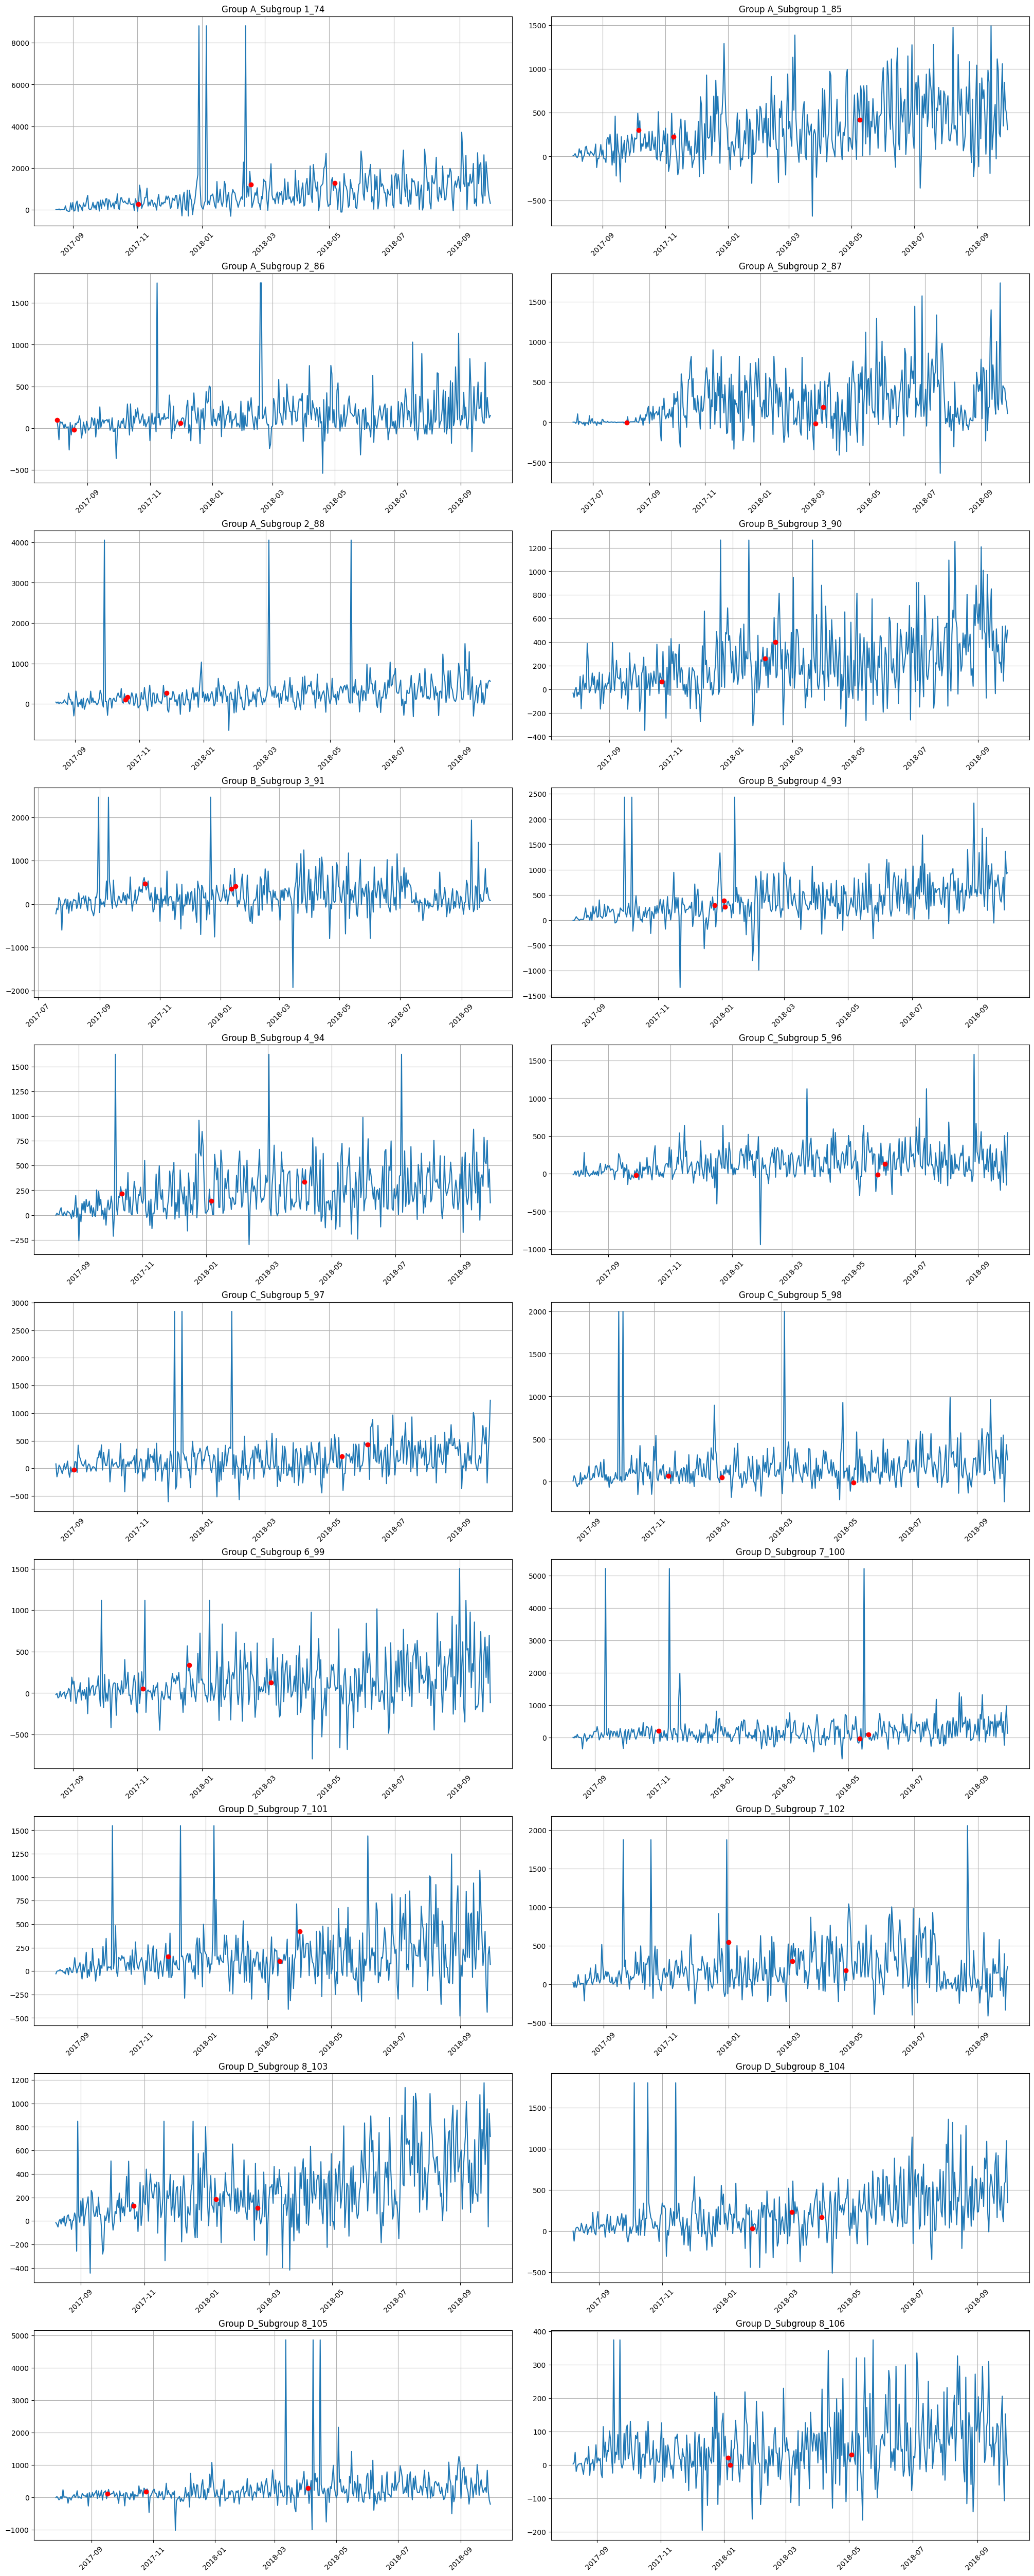

In [57]:
from etna.analysis import plot_imputation

transform = TimeSeriesImputerTransform(in_column="target", strategy="running_mean", window=3)

plot_imputation(
    df_hierarchical_ts,
    transform
)

df_hierarchical_ts.fit_transform([transform])

In [58]:
group_ts = df_hierarchical_ts.get_level_dataset("group")

pipeline_hierarchical = Pipeline(
    model=ProphetModel(),
    horizon=HORIZON
)

metriсs, forecasts, _ = pipeline_hierarchical.backtest(ts=group_ts, metrics=[MAE()], n_folds=1)

21:43:08 - cmdstanpy - INFO - Chain [1] start processing
21:43:08 - cmdstanpy - INFO - Chain [1] done processing
21:43:08 - cmdstanpy - INFO - Chain [1] start processing
21:43:08 - cmdstanpy - INFO - Chain [1] done processing
21:43:08 - cmdstanpy - INFO - Chain [1] start processing
21:43:08 - cmdstanpy - INFO - Chain [1] done processing
21:43:08 - cmdstanpy - INFO - Chain [1] start processing
21:43:08 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s


In [59]:
metrics.mean()

segment        2.502503e+91
SMAPE          7.023364e+01
MAE            2.431669e+02
fold_number    5.000000e-01
dtype: float64

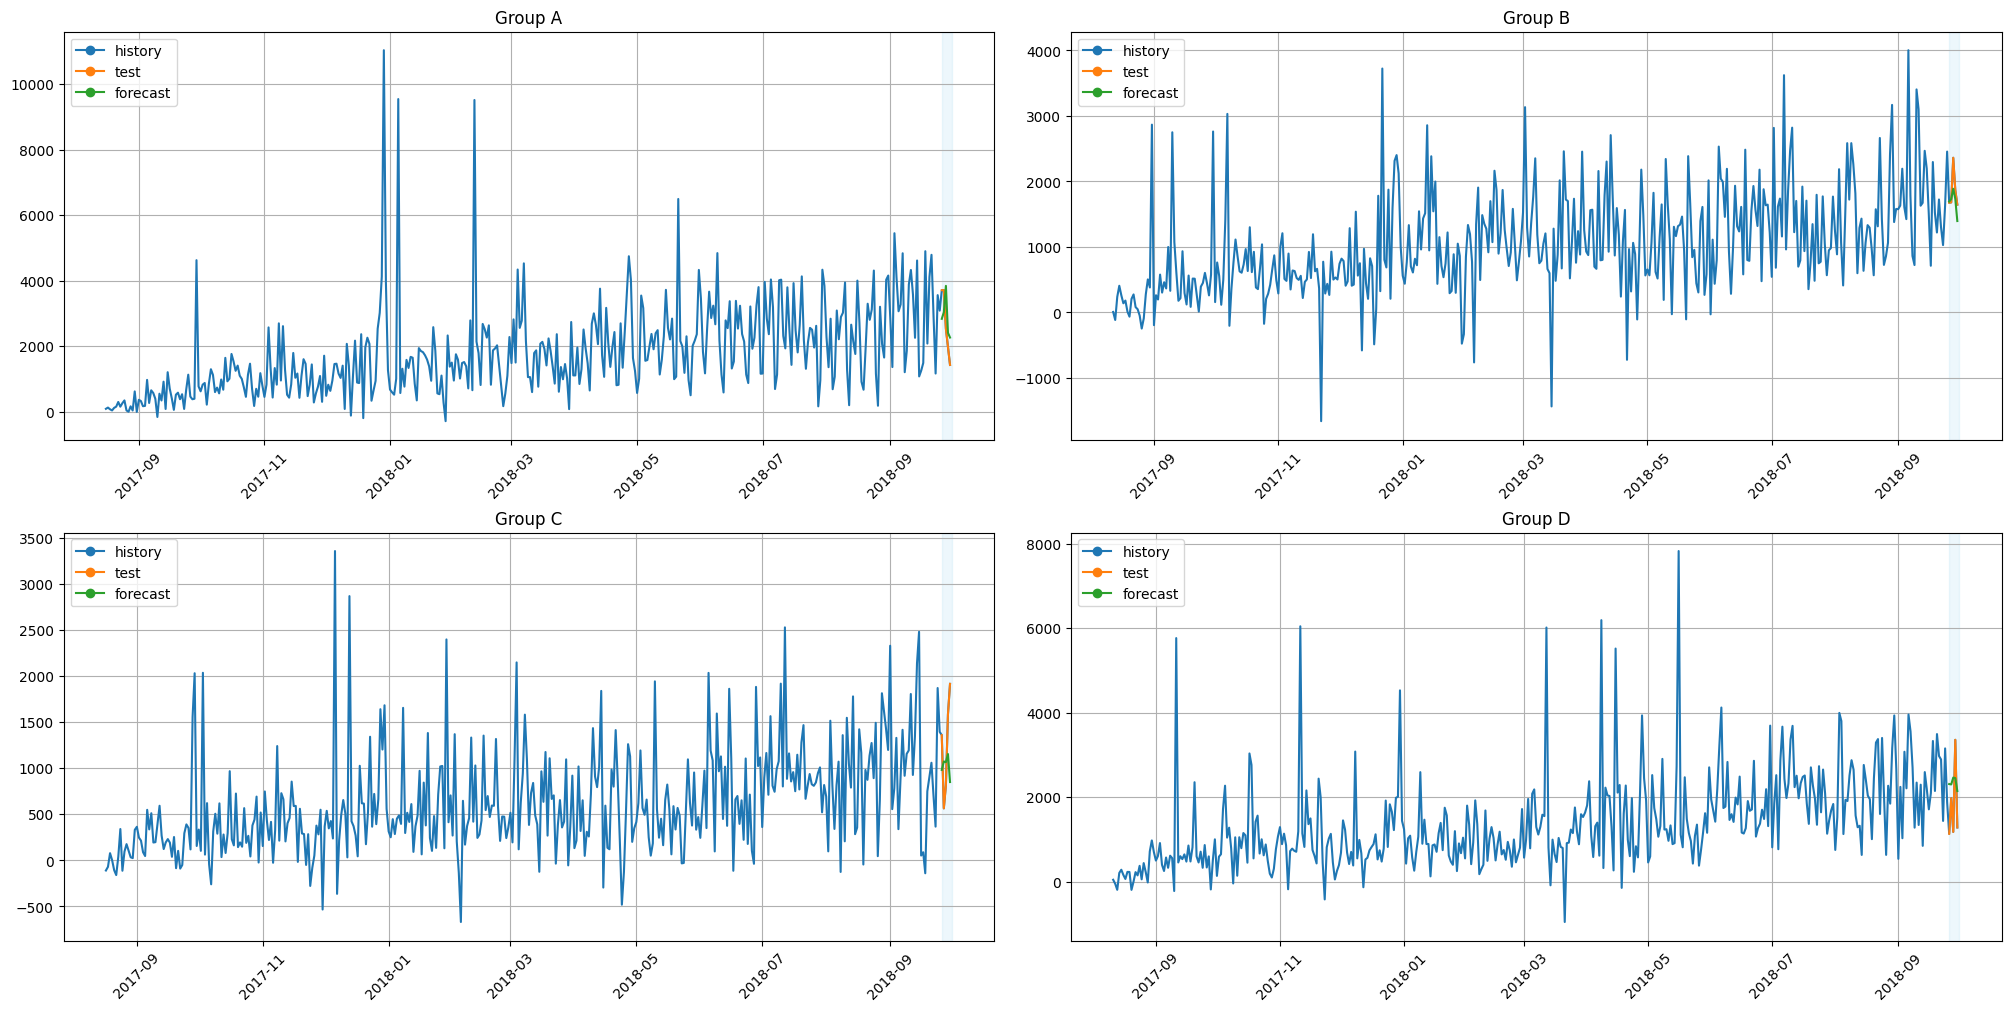

In [60]:
plot_backtest(forecast_df=forecasts, ts=group_ts, history_len=1000)

### Задание 5. Построение модели ARIMA (1 балл)

Попробуйте построить модель `ARIMA` на данных. Подберите оптимальные параметры модели, и оцените качество прогноза на кросс-валидации.  

Для этого могут быть полезны `ACF` и `PACF` диаграммы, которые вы возможно уже строили в первом задании.

In [61]:
from etna.analysis import acf_plot, stl_plot
from etna.models import SARIMAXModel

А теперь используйте `AutoARIMA`. Какие параметры он выбрал? Какое качество прогноза он показал?

In [62]:
params_dict = [
    {"order": (0, 0, 1), "seasonal_order": (0, 0, 1, 10)},
    {"order": (0, 1, 1), "seasonal_order": (0, 1, 1, 10)},
    # {"order": (1, 0, 1), "seasonal_order": (1, 0, 1, 8)},
    {"order": (1, 1, 1), "seasonal_order": (1, 1, 1, 10)},
]

best_params = None
best_score = None

for params in params_dict:
  model = SARIMAXModel(order=params["order"], seasonal_order=params["seasonal_order"])
  pipeline = Pipeline(model=model, horizon=HORIZON)
  metrics, forecasts, _ = pipeline.backtest(ts=df_atm_tsd_transformed, metrics=[MAE()], n_folds=3)
  mean_mae = metrics["MAE"].mean()
  print(f"params = {params}, mean_mae = {mean_mae}")
  if best_score is None or mean_mae < best_score:
    best_score = mean_mae
    best_params = params

print(f"best_params: {best_params}, best_score (MAE): {best_score}")

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    4.8s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:   10.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:   14.4s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:   14.4s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    2.7s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    2.7s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s


params = {'order': (0, 0, 1), 'seasonal_order': (0, 0, 1, 10)}, mean_mae = 351.5904773941699


[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    9.2s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:   18.9s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:   28.8s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:   28.8s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    2.7s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    2.7s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s


params = {'order': (0, 1, 1), 'seasonal_order': (0, 1, 1, 10)}, mean_mae = 267.41519992503856


[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:   25.7s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:   56.4s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:  1.4min
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:  1.4min
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    1.8s


params = {'order': (1, 1, 1), 'seasonal_order': (1, 1, 1, 10)}, mean_mae = 268.90173457357577
best_params: {'order': (0, 1, 1), 'seasonal_order': (0, 1, 1, 10)}, best_score (MAE): 267.41519992503856


[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    2.7s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    2.7s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s


In [63]:
best_model = SARIMAXModel(order=best_params["order"], seasonal_order=best_params["seasonal_order"])
pipeline = Pipeline(model=best_model, horizon=HORIZON)

metrics, _, _ = pipeline.backtest(
    ts=df_atm_tsd_transformed,
    metrics=[MAE()],
    n_folds=3
)

metrics

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    9.2s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:   19.3s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:   29.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:   29.0s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    2.7s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    2.7s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s


segment         MAE  fold_number
0      100  249.427943            0
0      100  159.597957            1
0      100  323.248367            2
1      101  323.173557            0
1      101  228.835771            1
1      101  326.035180            2
2      102  123.462570            0
2      102  143.096723            1
2      102  245.707492            2
3      103  324.456698            0
3      103  254.536446            1
3      103  356.875966            2
4      104  273.005846            0
4      104  225.464963            1
4      104  286.286133            2
5      105  319.994172            0
5      105  204.879932            1
5      105  446.503448            2
6      106   37.701747            0
6      106   83.824336            1
6      106  100.814688            2
7       74  911.643167            0
7       74  980.190613            1
7       74  738.576381            2
8       85  332.728493            0
8       85  351.524310            1
8       85  150.713843            2
9       86  140.465050            0
9       86  241.235577            1
9       86  101.871154            2
10      87  353.073160            0
10      87  380.545183            1
10      87  213.565638            2
11      88  196.598261            0
11      88  288.353380            1
11      88   87.793021            2
12      90  175.873478            0
12      90  160.918717            1
12      90  116.739666            2
13      91  408.717573            0
13      91  194.866117            1
13      91   86.683455            2
14      93  237.189845            0
14      93  219.091170            1
14      93  352.970041            2
15      94  229.606252            0
15      94  160.935872            1
15      94  202.626645            2
16      96  184.388559            0
16      96  211.696750            1
16      96  246.191056            2
17      97  219.755606            0
17      97  262.390906            1
17      97  433.564095            2
18      98  138.623050            0
18      98  123.852421            1
18      98  215.682277            2
19      99  319.556320            0
19      99  344.713488            1
19      99  292.471471            2

In [64]:
from etna.models import AutoARIMAModel

auto_arima_model = AutoARIMAModel()

pipeline = Pipeline(model=auto_arima_model, horizon=HORIZON)

metrics, forecasts, _ = pipeline.backtest(ts=df_atm_tsd_transformed, metrics=[MAE()], n_folds=3)

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:  2.3min
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:  4.6min
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:  7.6min
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:  7.6min
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    2.8s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    2.8s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s


In [66]:
metrics["MAE"].mean()

260.70138248707246

### Задание 6. Построение признаков (1.5 балла)

Теперь поработаем с моделями, которые требуют построения признаков на примере `CatBoost`.  
Построим для них признаки, и попробуем при помощи них добиться улучшения качества.

Из обязательного:
1) постройте графики автокорреляции (если еще не построили) и при помощи них обоснуйте выбор лаговых признаков
2) для катбуста включите в признаки результаты STL разложения. STL используем для убирания тренда за счет преобразования на месте.
* Кроме этого, подумайте на экспертном уровне,
    - Какие еще закономерности могут присутствовать и почему?
    - Что из этого кажется более предсказуемым, и почему?
    - Cделайте соответствующие признаки, и снабдите их кратким комментарием.

3) После этого, обучите на получившихся признаках модели. Для `CatBoost` рассмотрите 2 версии мультисегментную и на каждый ряд в отдельности.

Ниже приведены импорты, которые вам точно понадобятся - к ним необходимо добавить те инструменты, которые вы дополнительно решите использовать в анализе.

In [67]:
from etna.analysis import acf_plot, stl_plot
from etna.ensembles import DirectEnsemble, StackingEnsemble, VotingEnsemble
from etna.models import CatBoostMultiSegmentModel, CatBoostPerSegmentModel
from etna.transforms import STLTransform, LagTransform, SegmentEncoderTransform

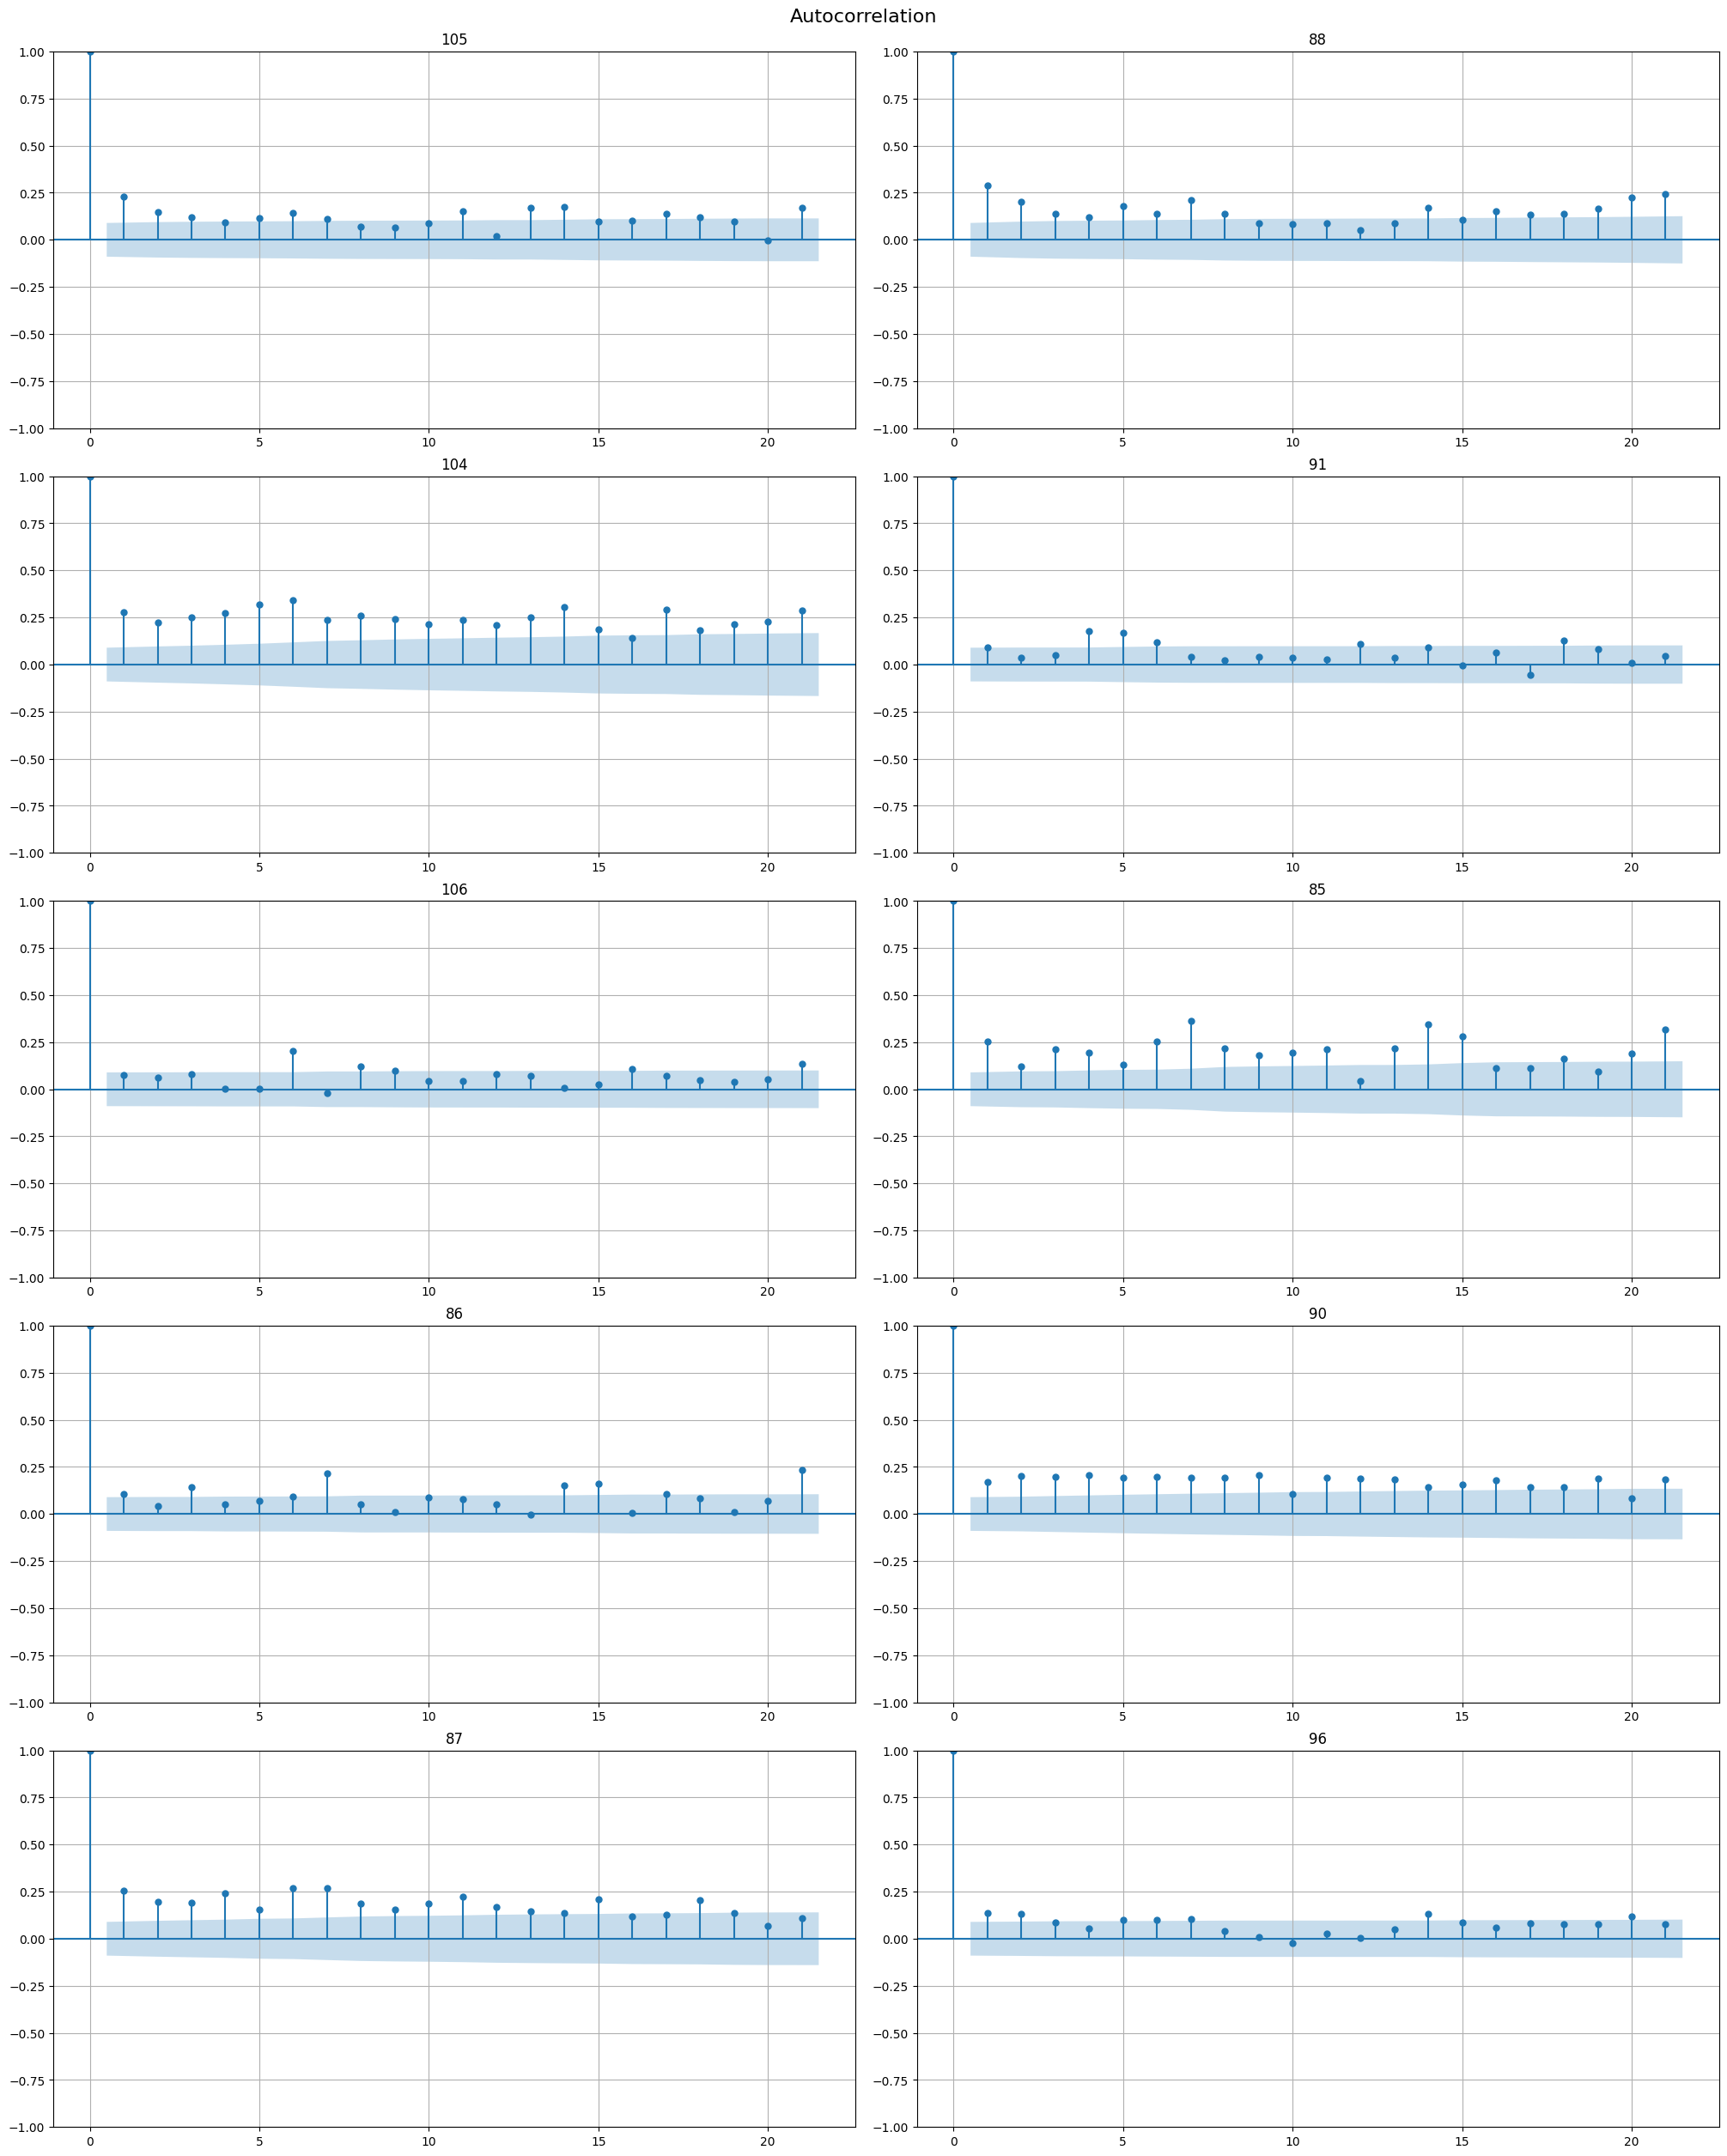

In [68]:
acf_plot(df_atm_tsd, lags=21)

In [69]:
ts = deepcopy(df_atm_tsd_transformed)

In [70]:
num_lags = 3

transform_lag = LagTransform(
    in_column="target", 
    lags=[HORIZON + i for i in range(num_lags)],
    out_column="target_lag",
)

transform_stl = STLTransform(
    in_column="target",
    period=HORIZON
)

transform_segment_encoder = SegmentEncoderTransform()

# CatBoostPerSegmentModel

In [71]:
train_ts, test_ts = ts.train_test_split(
    test_start="2018-09-26",
    test_end="2018-09-30",
)

cat_boost_multy_segmental = CatBoostMultiSegmentModel(
    iterations=1000,
    learning_rate=0.05,
)

pipeline = Pipeline(
    model=cat_boost_multy_segmental,
    horizon=HORIZON,
    transforms=[
        transform_stl,
        transform_lag,
        transform_segment_encoder
    ]
)

pipeline.fit(train_ts)
forecast_ts = pipeline.forecast()

In [72]:
metric = SMAPE()(y_true=test_ts, y_pred=forecast_ts)
print(f"Mean SMAPE of CatBoostPerSegmentModel: {np.array(list(metric.values())).mean()}")

Mean SMAPE of CatBoostPerSegmentModel: 98.99874062858949


# CatBoostMultiSegmentModel

In [73]:
train_ts, test_ts = ts.train_test_split(
    test_start="2018-09-26",
    test_end="2018-09-30",
)

cat_boost_per_segmental = CatBoostPerSegmentModel(
    iterations=1000,
    learning_rate=0.05,
)

pipeline = Pipeline(
    model=cat_boost_per_segmental,
    horizon=HORIZON,
    transforms=[
        transform_stl,
        transform_lag,
        transform_segment_encoder
    ]
)

pipeline.fit(train_ts)
forecast_ts = pipeline.forecast()

In [74]:
metric = SMAPE()(y_true=test_ts, y_pred=forecast_ts)
print(f"Mean SMAPE of CatBoostPerSegmentModel: {np.array(list(metric.values())).mean()}")

Mean SMAPE of CatBoostPerSegmentModel: 102.7327635491441


### Задание 7. Стратегии прогнозирования (1.25 балла)

Как нам известно по семинарским занятиям, при построении прогноза на горизонте дальше следующего наблюдения перед нами встает задача определиться со стратегией генерации прогноза. Попробуйте разные стратегии на нашем горизонте из 5 дней (прямая, рекурсивная). Какая стратегия в совокупности с какой моделью дает лучший результат?

Учитывайте особенности, которые некоторые стратегии могут накладывать на признаки (в частности, на лаговые переменные).

При необходимости, в смешанном методе пользуйтесь упрощенной схемой спецификации моделей/преобразований.

In [79]:
from etna.pipeline import AutoRegressivePipeline, Pipeline, assemble_pipelines
from etna.ensembles import DirectEnsemble
from etna.metrics import SMAPE, MAE, MAPE

In [81]:
horizons = [HORIZON, HORIZON * 2]
num_lags = 3

transforms = [
    LinearTrendTransform(in_column="target"),
    [
        LagTransform(
            in_column="target",
            lags=[i for i in range(horizons[0], horizons[0] + num_lags)],
            out_column="target_lag",
        ),
        LagTransform(
            in_column="target",
            lags=[i for i in range(horizons[1], horizons[1] + num_lags)],
            out_column="target_lag",
        ),
    ],
]

models = [CatBoostMultiSegmentModel(), CatBoostMultiSegmentModel()]

In [82]:
pipelines = assemble_pipelines(models=models, transforms=transforms, horizons=horizons)
pipelines

[Pipeline(model = CatBoostMultiSegmentModel(iterations = None, depth = None, learning_rate = None, logging_level = 'Silent', l2_leaf_reg = None, thread_count = None, ), transforms = [LinearTrendTransform(in_column = 'target', poly_degree = 1, ), LagTransform(in_column = 'target', lags = [5, 6, 7], out_column = 'target_lag', )], horizon = 5, ),
 Pipeline(model = CatBoostMultiSegmentModel(iterations = None, depth = None, learning_rate = None, logging_level = 'Silent', l2_leaf_reg = None, thread_count = None, ), transforms = [LinearTrendTransform(in_column = 'target', poly_degree = 1, ), LagTransform(in_column = 'target', lags = [10, 11, 12], out_column = 'target_lag', )], horizon = 10, )]

In [83]:
direct_ensemble = DirectEnsemble(pipelines=pipelines)

metrics, _, _ = direct_ensemble.backtest(ts=ts, metrics=[SMAPE(), MAE(), MAPE()])


metrics[['SMAPE', 'MAE', 'MAPE']].mean()

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    2.8s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    2.8s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    2.8s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    2.9s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    2.9s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    5.8s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    2.8s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    2.8s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    8.8s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    2.9s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    2.9s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:   11.7s
[Parallel(n_jobs=1)]: Do

SMAPE    8.347796e+01
MAE      2.844516e+02
MAPE     4.191360e+18
dtype: float64

### Задание 8. Ансамбли (1.25 балла)

Чтобы не выбирать лучшую модель, мы можем использовать преимущества каждой - давайте объединим все наши наработки в ансамбль. Попробуйте различные опции ансамблирования, и выберите ту, которая работает лучше всего (не забывайте, что внутри каждого ансамбля у нас тоже есть параметры, которые мы можем варьировать - веса в voting, включаемые признаки в stacking).

In [84]:
from etna.ensembles import StackingEnsemble, VotingEnsemble

In [85]:
N_FOLDS = 3

In [86]:
from etna.models import NaiveModel
from etna.models import SeasonalMovingAverageModel
from etna.metrics import MSE
from etna.metrics import MAPE

In [ ]:
naive_pipeline = Pipeline(model=NaiveModel(lag=3), transforms=[], horizon=HORIZON)

seasonalma_pipeline = Pipeline(
    model=SeasonalMovingAverageModel(window=5),
    transforms=[],
    horizon=HORIZON,
)

catboost_pipeline = Pipeline(
    model=CatBoostMultiSegmentModel(),
    transforms=[LagTransform(lags=[1, 2, 3], in_column="target")],
    horizon=HORIZON,
)

pipeline_names = ["naive", "moving average", "catboost"]
pipelines = [
    naive_pipeline, 
    seasonalma_pipeline, 
    catboost_pipeline
]

In [ ]:
metrics = []

for name, pipeline in zip(pipeline_names, pipelines):
    result = pipeline.backtest(
        ts=ts,
        metrics=[MAE(), MSE(), SMAPE(), MAPE()],
        n_folds=N_FOLDS,
        aggregate_metrics=True,
    )[0]
    result['model'] = name
    metrics.append(result)

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

In [97]:
metrics = pd.concat(metrics)

In [98]:
metrics.groupby('model').mean()

MAE            MSE       SMAPE          MAPE
model                                                              
catboost        423.537812  387933.017840  134.818541  2.172836e+18
moving average  265.017095  132091.467833   82.353475  3.042597e+18
naive           364.457469  261660.440245  102.254563  3.746145e+18

In [99]:
voting_ensemble = VotingEnsemble(pipelines=pipelines, weights=[0.2, 0.6, 0.2])

In [100]:
voting_ensamble_metrics = voting_ensemble.backtest(
    ts=ts,
    metrics=[MAE(), MSE(), SMAPE(), MAPE()],
    n_folds=N_FOLDS,
    aggregate_metrics=True,
)[0]

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    2.8s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    4.3s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    4.3s
[Parallel(n_jobs=1)]: Do

In [101]:
voting_ensamble_metrics['model'] = "votingensemble"

In [102]:
voting_ensamble_metrics.groupby('model').mean()

MAE            MSE      SMAPE          MAPE
model                                                             
votingensemble  263.785447  135867.969782  82.699583  2.703726e+18

In [103]:
stacking_ensemble_unfeatured = StackingEnsemble(pipelines=pipelines, n_folds=N_FOLDS)

In [104]:
stacking_ensamble_metrics = stacking_ensemble_unfeatured.backtest(
    ts=ts,
    metrics=[MAE(), MSE(), SMAPE(), MAPE()],
    n_folds=N_FOLDS,
    aggregate_metrics=True,
)[0]

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

In [105]:
stacking_ensamble_metrics['model'] = "stackingensemble"

In [106]:
stacking_ensamble_metrics.groupby('model').mean()

MAE            MSE      SMAPE          MAPE
model                                                               
stackingensemble  264.834497  129000.875109  75.899562  3.790376e+18

### Задание 9. Итоговое сравнение (1 балл)

Сравните все модели между собой по метрикам качества, которые вы использовали. Какая модель оказалась лучше? Почему? Какие выводы можно сделать?


In [107]:
result_metrics = pd.concat([metrics, voting_ensamble_metrics, stacking_ensamble_metrics])
result_metrics.groupby("model")[["MAE", "MSE", "SMAPE", "MAPE"]].mean().reset_index()

model         MAE            MSE       SMAPE          MAPE
0          catboost  423.537812  387933.017840  134.818541  2.172836e+18
1    moving average  265.017095  132091.467833   82.353475  3.042597e+18
2             naive  364.457469  261660.440245  102.254563  3.746145e+18
3  stackingensemble  264.834497  129000.875109   75.899562  3.790376e+18
4    votingensemble  263.785447  135867.969782   82.699583  2.703726e+18

Лучше всего оказался stackingensemble. 

### Задание 10*. Трансформер (бонус 2 балла)

Для желающих протестировать мощь трансформенных моделей предлагается "завести" модель из второго семинара по временным рядам на текущем датасете. На этот раз абсолютно все необходимые импорты и зависимости подгружаются на ваше усмотрение. Удалось ли вам улучшить качество по сравнению с классическими моделями / моделями на основе ML? Что бы вы предпочли внедрить в production?

*NB:* все, конечно, прекрасно знают механизм работы бонусных заданий, но порядка ряди прописать дисклеймер должны - итоговый балл за домашнее задание ставится по формуле min(10, ваш суммарный балл за задания).

In [45]:
#YOUR CODE HERE#